In [ ]:
import random
import copy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading the merged train and test dataset

train_data = pd.read_pickle('/content/drive/MyDrive/Sanju Sarkar/Credit Card Fraud Detection/advanced_fe_train.pkl')
test_data = pd.read_pickle('/content/drive/MyDrive/Sanju Sarkar/Credit Card Fraud Detection/advanced_fe_test.pkl')

In [ ]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(train_data.shape))
print("\n Test Data Shape : {} \n".format(test_data.shape))
print("*"*45)

*********************************************

 Train Data Shape : (590538, 309) 


 Test Data Shape : (506691, 308) 

*********************************************


In [ ]:
with open("/content/drive/MyDrive/Sanju Sarkar/Credit Card Fraud Detection/features_having_covariate_shift.pkl", 'rb') as handle:
  drop_cols = pickle.load(handle)

### Utility Functions
<br>

In [ ]:
def hyperparam_vs_auc(train_roc_auc, cv_roc_auc):

    '''
        Utility Function to plot the Training and Cross Validation ROC-AUC Values
        for different Hyperparameter.
    '''

    plt.plot(range(len(train_roc_auc)), train_roc_auc, label='Train AUC')
    plt.plot(range(len(cv_roc_auc)), cv_roc_auc, label='CV AUC')

    plt.scatter(range(len(train_roc_auc)), train_roc_auc, label='Train AUC points')
    plt.scatter(range(len(cv_roc_auc)), cv_roc_auc, label='CV AUC points')

    plt.xticks(range(len(train_roc_auc)))
    plt.legend()
    plt.xlabel("Hyperparameter Index")
    plt.ylabel("AUC")
    plt.title("\n Hyperparameter vs ROC-AUC \n")
    plt.grid()
    plt.show()

## Data Preparation
<br>

### Splitting the Dataset
<br>

In [ ]:
X_train = train_data.drop(['isFraud']+drop_cols, axis=1)
y_train = train_data['isFraud']

X_test = test_data.drop(drop_cols, axis=1)

del train_data, test_data

In [ ]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(X_train.shape))
print("\n Test Data Shape : {} \n".format(X_test.shape))
print("*"*45)

*********************************************

 Train Data Shape : (590538, 296) 


 Test Data Shape : (506691, 296) 

*********************************************


<br>

## Hyperparameter Tuning

<br>

In [1]:
# Hyperparameters

learning_rate = [2e-2, 3e-1, 1e-1]
max_depth = [8, 12, 16]
subsample = [0.6,0.8,1]
colsample_bytree = [0.6,0.8,1]

In [ ]:
results = {}

dtrain = xgb.DMatrix(X_train, label=y_train)

for rate in learning_rate:
  for depth in max_depth:
    for sample in subsample:
      for colsample in colsample_bytree:

        params = {
          'objective' : 'binary:logistic',
          'eval_metric' : 'auc',
          'learning_rate' : rate,
          'max_depth' : depth,
          'subsample' : sample,
          'colsample_bytree' : colsample,
          'tree_method' : 'gpu_hist',
          'random_state' : 3,
        }

        history = xgb.cv(
            params,
            dtrain,
            num_boost_round = 3000,
            nfold = 3,
            metrics ='auc',
            early_stopping_rounds = 100,
            verbose_eval=100,
            seed=3,
            shuffle = False
        )

        name = "learning_rate : "+str(rate)+" max_depth : "+str(depth)+" subsample : "+str(sample)+" colsample_bytree : "+str(colsample)
        results[name] = (history.iloc[-1]['train-auc-mean'],history.iloc[-1]['test-auc-mean'])

[0]	train-auc:0.81078+0.00771	test-auc:0.79608+0.00582
[100]	train-auc:0.91747+0.00401	test-auc:0.88132+0.00870
[200]	train-auc:0.95364+0.00217	test-auc:0.90281+0.00971
[300]	train-auc:0.96955+0.00132	test-auc:0.91364+0.00871
[400]	train-auc:0.97734+0.00058	test-auc:0.91838+0.00844
[500]	train-auc:0.98230+0.00050	test-auc:0.92057+0.00828
[600]	train-auc:0.98603+0.00034	test-auc:0.92210+0.00819
[700]	train-auc:0.98876+0.00027	test-auc:0.92257+0.00810
[800]	train-auc:0.99100+0.00018	test-auc:0.92296+0.00789
[900]	train-auc:0.99286+0.00010	test-auc:0.92298+0.00806
[1000]	train-auc:0.99433+0.00010	test-auc:0.92298+0.00795
[1020]	train-auc:0.99460+0.00011	test-auc:0.92284+0.00799
[0]	train-auc:0.81653+0.01074	test-auc:0.80138+0.01467
[100]	train-auc:0.91679+0.00440	test-auc:0.87966+0.00964
[200]	train-auc:0.95466+0.00213	test-auc:0.90251+0.00958
[300]	train-auc:0.97023+0.00139	test-auc:0.91270+0.00891
[400]	train-auc:0.97807+0.00077	test-auc:0.91769+0.00826
[500]	train-auc:0.98274+0.00059	t

In [ ]:
with open ('/content/drive/MyDrive/Sanju Sarkar/Credit Card Fraud Detection/xgb_cv_results.pkl', 'rb') as handle:
  results = pickle.load(handle)

FileNotFoundError: ignored

In [ ]:
train_roc_auc = [auc[0] for auc in results.values()]
cv_roc_auc = [auc[1] for auc in results.values()]

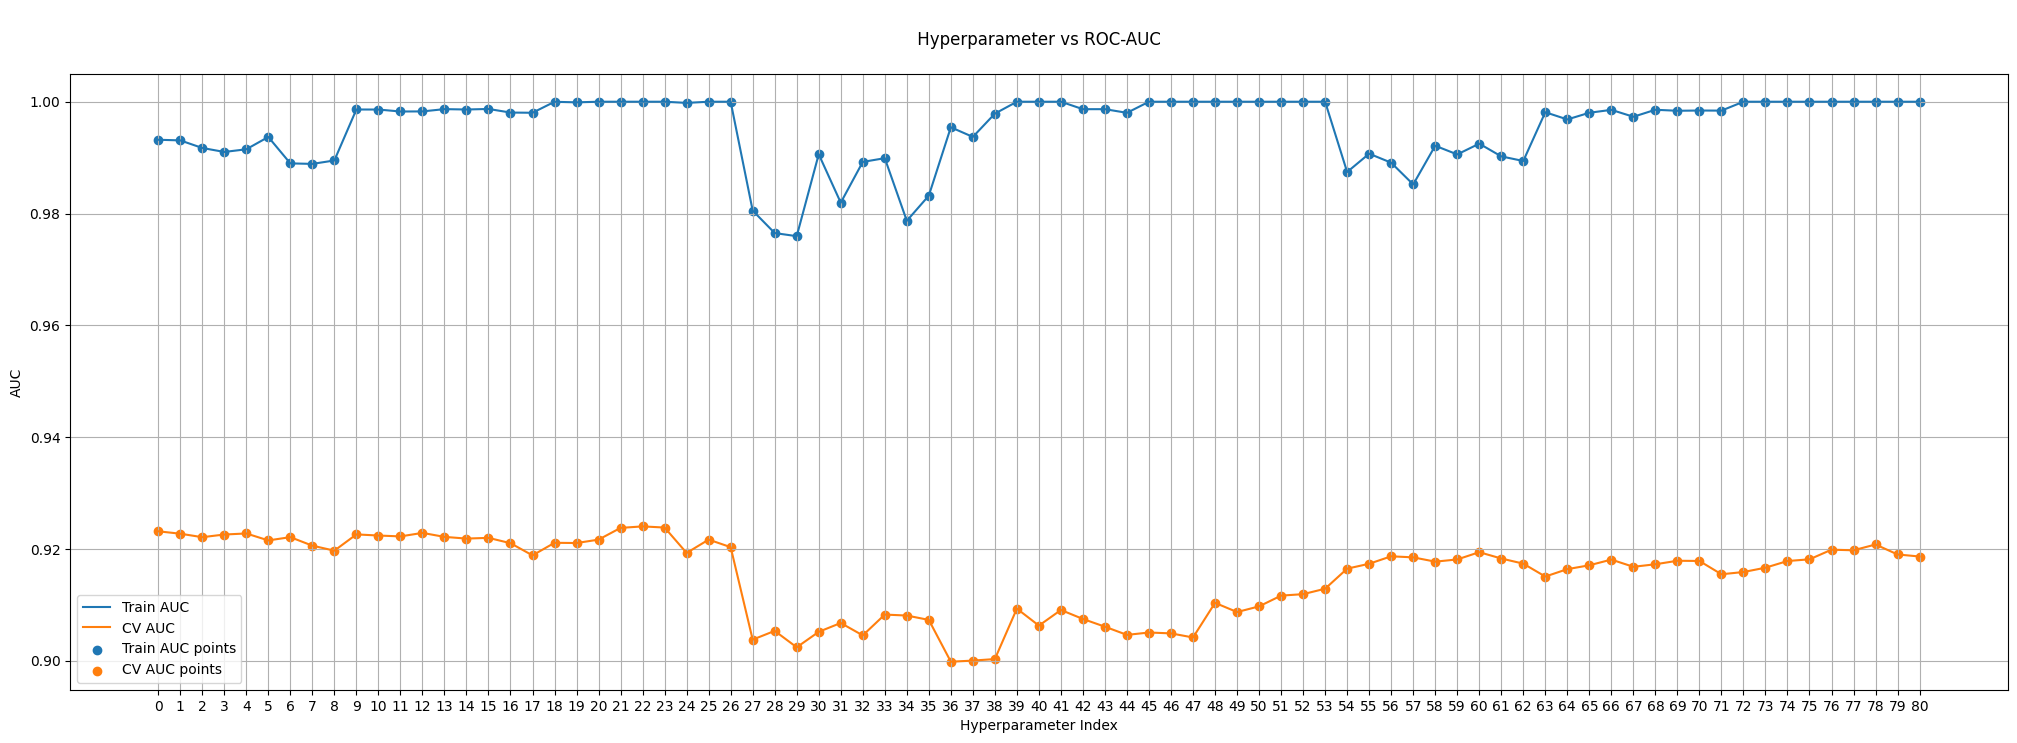

In [ ]:
plt.figure(figsize=(25,8))
hyperparam_vs_auc(train_roc_auc, cv_roc_auc)

From the above plot, the best hyperaparameter index is 3.
<br><br>

In [ ]:
best_params = list(results.keys())[3]

In [ ]:
print("The Best Paramaters are {} ".format(best_params))

The Best Paramaters are learning_rate : 0.02 max_depth : 8 subsample : 0.8 colsample_bytree : 0.6 
